In [1]:
# !pip install -r requirements.txt

In [2]:
from AD_COMET_LTCR import COMET
from models.encoder import FTClassifier
# import datautils
from tasks.fine_tuning import finetune_fit
from tasks.fine_tuning import finetune_predict
from tasks.linear_evaluation import eval_classification
from dataloading.ad_preprocessing import load_ad
from config_files.AD_Configs import Config as Configs
from dct_func import FFT_for_Period
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import sklearn
from utils_cpc import plot_channels # 多加一个sample id
from utils_cpc import process_batch_ts
from utils_cpc import split_data_label
from utils_cpc import start_logging
from utils_cpc import stop_logging
from utils_cpc import seed_everything

from datetime import datetime

In [3]:
configs = Configs()
RANDOM_SEED = configs.RANDOM_SEED

# Autoload the modified python file
%reload_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Specify saving and logging directory

In [4]:
working_directory = configs.working_directory
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = configs.logging_directory
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

#### Load and preprocessing data

In [5]:
data_path = "datasets/AD/Feature/"
label_path = "datasets/AD/Label/label.npy"
val_ids = [17,18]  # specify patient ID for validation and test set
test_ids = [19,20]
X_trial_train, X_trial_val, X_trial_test, y_trial_train, y_trial_val, y_trial_test = load_ad(val_ids, test_ids, data_path, label_path)
print(X_trial_train.shape)
print(y_trial_train.shape)
print(X_trial_val.shape)
print(y_trial_val.shape)
print(X_trial_test.shape)
print(y_trial_test.shape)

Validation subjects:  [17, 18]
Test subjects:  [19, 20]
(481, 1280, 16)
(481, 2)
(99, 1280, 16)
(99, 2)
(83, 1280, 16)
(83, 2)


In [6]:
# normalize data
X_trial_train = process_batch_ts(X_trial_train, normalized=True, bandpass_filter=False)
X_trial_val = process_batch_ts(X_trial_val, normalized=True, bandpass_filter=False)
X_trial_test = process_batch_ts(X_trial_test, normalized=True, bandpass_filter=False)
print(X_trial_train.shape)
print(X_trial_val.shape)
print(X_trial_test.shape)

(481, 1280, 16)
(99, 1280, 16)
(83, 1280, 16)


In [7]:
# periodicity, freq_list = FFT_for_Period(torch.tensor(X_trial_train), 8) # 
# periodicity = torch.from_numpy(np.array([periodicity]))
# # periodicity = periodicity.item()
# periodicity
# tensor([[1280,  640,  426,  320,  256,  213,  182,  160]])

In [8]:
# Split trail-level data into sample-level data
X_train, y_train = split_data_label(X_trial_train,y_trial_train, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
X_val, y_val = split_data_label(X_trial_val,y_trial_val, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
X_test, y_test = split_data_label(X_trial_test,y_trial_test, sample_timestamps=configs.S_TIMESTAMPS, overlapping=configs.S_OVERLAPPING)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4329, 4)
(891, 4)
(747, 4)
(4329, 256, 16)
(891, 256, 16)
(747, 256, 16)
(4329, 4)
(891, 4)
(747, 4)


In [9]:
del X_trial_train
del X_trial_val
del X_trial_test

In [10]:
# # plot first sample, first four channels
# plot_channels(1, X_trial_train[0][:,:])

In [11]:
# torch.__version__


In [12]:
import torch

# 
print("PyTorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())

# 
print("cuDNN available:", torch.backends.cudnn.enabled)


PyTorch version: 2.1.2+cu118
GPU available: True
cuDNN available: True


## Train model

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The program will run on {device}!")
# device = "cuda"

The program will run on cuda!


### Callback functions

In [14]:
def pretrain_callback(model, loss):
    n = model.n_epochs
    metrics_dict = {}
    if n % 1 == 0:
        metrics_dict = eval_classification(model, X_train, y_train[:, 0], X_val, y_val[:, 0], fraction=1)
        print(metrics_dict)
        model.save(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")
    return metrics_dict['F1']

In [15]:
def finetune_callback(model, f1, fraction=1.0):
    n = model.n_epochs
    if model.n_epochs == 1:
        model.finetune_f1 = f1
        torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    # control the saving frequency
    if n % 1 == 0:
        if f1 > model.finetune_f1:
            model.finetune_f1 = f1
            torch.save(model.state_dict(), f"{working_directory}seed{RANDOM_SEED}_max_f1_{fraction}_finetune_model.pt")
    return finetune_callback

## Self-Supervised

In [16]:
start_time = datetime.now()
# Train a COMET model
seed_everything(RANDOM_SEED)
model = COMET(
    input_dims=configs.input_dims,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    flag_use_multi_gpu=configs.flag_use_multi_gpu,
    after_epoch_callback=pretrain_callback,
    top_k_list = [640, 426],
    contrast_cycle = True,
    contrast_trend = True,
    sample_len = 256,
    overlap_len = 128
)

epoch_loss_list, epoch_f1_list = model.fit(
    X_train,
    y_train,
    shuffle_function = configs.shuffle_function,
    verbose=configs.verbose,
    n_epochs=configs.n_epochs,
    masks = configs.masks,
    factors = configs.factors
)

end_time = datetime.now()
print(f'Duration: {end_time - start_time}')

Epoch #1: loss=17.617831071217854
{'Accuracy': 0.7710437710437711, 'Precision': 0.7962573591253155, 'Recall': 0.7985169491525423, 'F1': 0.7710204081632652, 'AUROC': 0.9290594266582965, 'AUPRC': 0.9259813722965675}
Epoch #2: loss=13.608164575364855
{'Accuracy': 0.8237934904601572, 'Precision': 0.8275286283609948, 'Recall': 0.8396421845574389, 'F1': 0.822699152451073, 'AUROC': 0.933286252354049, 'AUPRC': 0.9303235090073259}
Epoch #3: loss=13.378955099317762
{'Accuracy': 0.8372615039281706, 'Precision': 0.8351860254083485, 'Recall': 0.8478107344632768, 'F1': 0.835350117566095, 'AUROC': 0.9353421217827997, 'AUPRC': 0.9323442310830465}
Epoch #4: loss=13.281259536743164
{'Accuracy': 0.8395061728395061, 'Precision': 0.8364135864135864, 'Recall': 0.8487994350282486, 'F1': 0.8373749325123776, 'AUROC': 0.9307961916718981, 'AUPRC': 0.9284967427959616}
Epoch #5: loss=13.13095596101549
{'Accuracy': 0.8451178451178452, 'Precision': 0.8415720127214903, 'Recall': 0.8539548022598871, 'F1': 0.8429366320

                                test

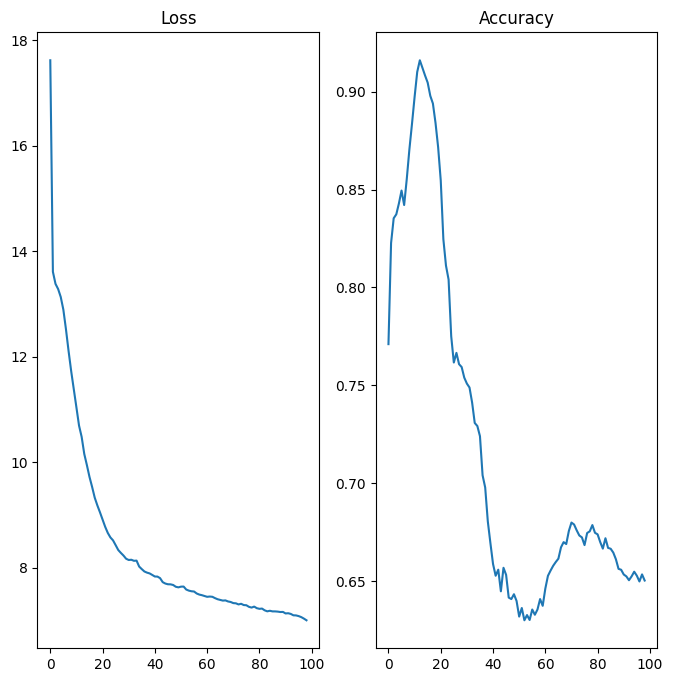

In [22]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Linear evaluation

In [23]:
start_time = datetime.now()
seed_everything(RANDOM_SEED)
pretrain_model = COMET(
    input_dims=configs.input_dims,
    device=device,
    lr=configs.pretrain_lr,
    depth=configs.depth,
    batch_size=configs.pretrain_batch_size,
    output_dims=configs.output_dims,
    flag_use_multi_gpu=configs.flag_use_multi_gpu,
    after_epoch_callback=pretrain_callback,
)

pretrain_model.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt")

start_logging(RANDOM_SEED, logging_directory)
val_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_val, y_val[:, 0])
print("Linear evaluation for validation set\n",val_metrics_dict)
test_metrics_dict = eval_classification(pretrain_model, X_train, y_train[:, 0], X_test, y_test[:, 0])
print("Linear evaluation for test set\n",test_metrics_dict)
print()
stop_logging()

Linear evaluation for validation set
 {'Accuracy': 0.6711560044893379, 'Precision': 0.6564555534673934, 'Recall': 0.6480696798493408, 'F1': 0.6502169873130419, 'AUROC': 0.708244402594685, 'AUPRC': 0.6990802239725569}


## Full fine-tuning

In [24]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [25]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_100, finetune_epochs=configs.finetune_epochs_100, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_100, fraction=configs.fraction_100, device=device, callback=finetune_callback)

Linear evaluation for test set
 {'Accuracy': 0.7576974564926372, 'Precision': 0.8478991596638655, 'Recall': 0.7282282282282282, 'F1': 0.7237092967416958, 'AUROC': 0.9605402503953229, 'AUPRC': 0.9598648938632691}

Epoch number: 0
Loss: 0.6606098220628851
{'Accuracy': 0.7441077441077442, 'Precision': 0.7843442350748268, 'Recall': 0.7777071563088511, 'F1': 0.7439371174459759, 'AUROC': 0.9007035990793053, 'AUPRC': 0.9145220451484825}
Epoch number: 1
Loss: 0.649150039343273
{'Accuracy': 0.5488215488215489, 'Precision': 0.7052748518762344, 'Recall': 0.6174435028248587, 'F1': 0.5214746056175452, 'AUROC': 0.9075617283950619, 'AUPRC': 0.9069484722291218}
Epoch number: 2
Loss: 0.6428809686034334
{'Accuracy': 0.5028058361391695, 'Precision': 0.6811140487922125, 'Recall': 0.5788370998116761, 'F1': 0.45882651347404935, 'AUROC': 0.880032433563507, 'AUPRC': 0.8757193834177035}
Epoch number: 3
Loss: 0.6380937826984069
{'Accuracy': 0.4612794612794613, 'Precision': 0.6661490683229814, 'Recall': 0.545338

In [26]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_100}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_100} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_100} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

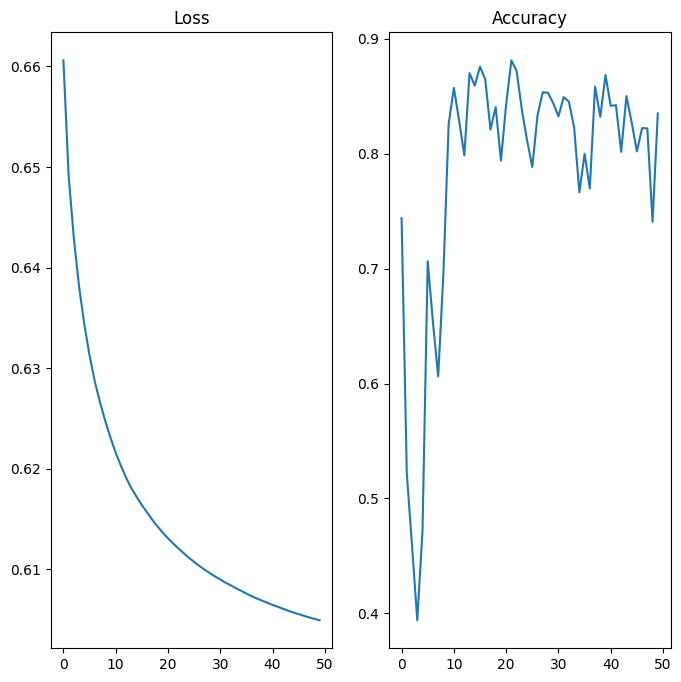

In [27]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

## Semi-supervised

### 10% label

In [28]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [29]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_10,finetune_epochs=configs.finetune_epochs_10, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_10, fraction=configs.fraction_10, device=device, callback=finetune_callback)

In [30]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_10}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_10} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_10} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

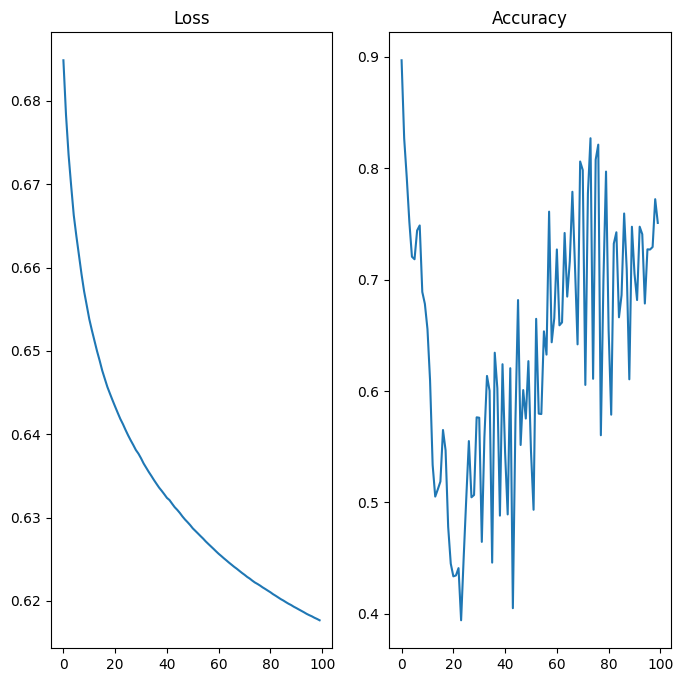

In [31]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

### 1% label

In [32]:
seed_everything(RANDOM_SEED)
finetune_model = FTClassifier(input_dims=configs.input_dims, output_dims=configs.output_dims, depth=configs.depth, p_output_dims=configs.num_classes, device=device, flag_use_multi_gpu=configs.flag_use_multi_gpu)
finetune_model.net.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_pretrain_model.pt"))

<All keys matched successfully>

In [33]:
seed_everything(RANDOM_SEED)
epoch_loss_list, epoch_f1_list = finetune_fit(finetune_model, X_train, y_train[:, 0], X_val, y_val[:, 0], batch_size=configs.finetune_batch_size_1,finetune_epochs=configs.finetune_epochs_1, num_classes=configs.num_classes, finetune_lr=configs.finetune_lr_1, fraction=configs.fraction_1, device=device, callback=finetune_callback)

In [34]:
finetune_model.load_state_dict(torch.load(f"{working_directory}seed{RANDOM_SEED}_max_f1_{configs.fraction_1}_finetune_model.pt"))
start_logging(RANDOM_SEED, logging_directory)
print(f"Finetune for {configs.fraction_1} fraction of validation set")
finetune_predict(finetune_model, X_val, y_val[:,0])
print(f"Finetune for {configs.fraction_1} fraction of test set")
finetune_predict(finetune_model, X_test, y_test[:,0])
print()
stop_logging()

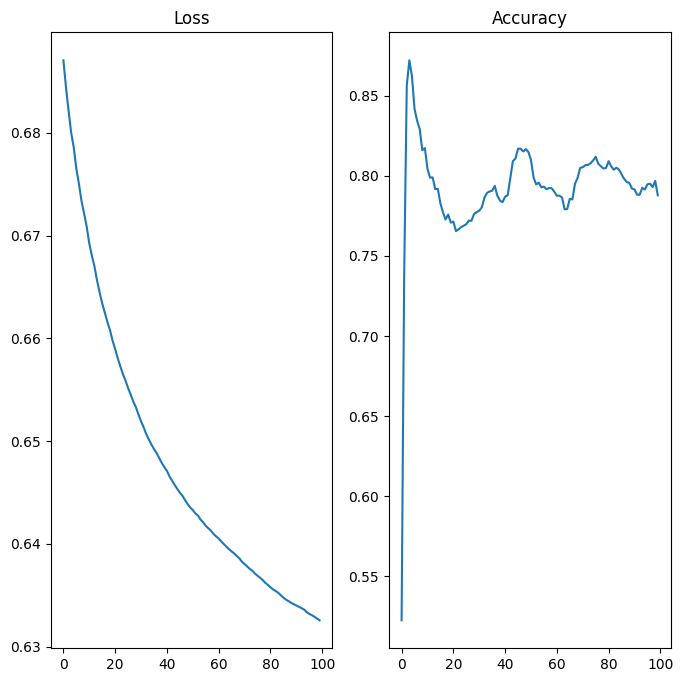

In [35]:
plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(epoch_loss_list)
plt.title('Loss')
plt.subplot(122)
plt.plot(epoch_f1_list)
plt.title('Accuracy')
plt.show()

In [36]:
end_time = datetime.now()
print(f'Duration: {end_time - start_time}')